ref: https://d2l.ai/

In [42]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt



# 1. 数据加载及预处理

# 1.1 数据下载

In [52]:
# Download training data from open datasets.
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
# Fashion-MNIST由10个类别的图像组成， 每个类别由训练数据集（train dataset）中的6000张图像 和测试数据集（test dataset）中的1000张图像组成。 
# 因此，训练集和测试集分别包含60000和10000张图像。 测试数据集不会用于训练，只用于评估模型性能。

# 会重复下载吗？--应该不会
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [10]:
print(len(train_data), len(test_data))
print(train_data)
print(train_data[0][0].shape)

60000 10000
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([1, 28, 28])


In [11]:
# Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、
# sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。 
# 以下函数用于在数字标签索引及其文本名称之间进行转换。

def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [13]:
get_fashion_mnist_labels([1,2,3,4])

['trouser', 'pullover', 'dress', 'coat']

In [20]:
# 可视化这些样本的函数
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

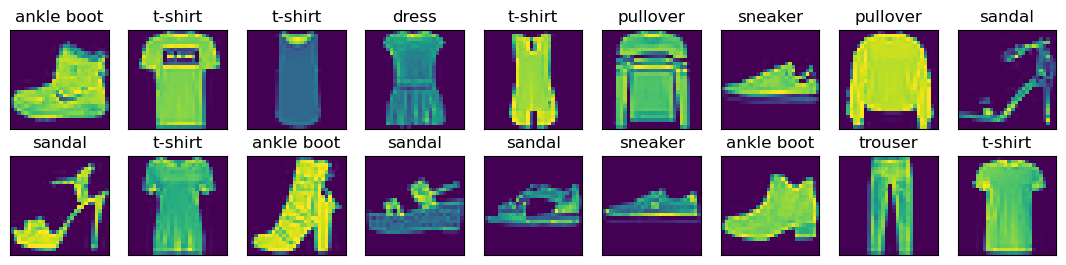

In [25]:
# 以下是训练数据集中前几个样本的图像及其相应的标签。
# 如果要取中间任意的某几个图像，应该如何修改代码实现呢？
X, y = next(iter(DataLoader(train_data, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));


# 1.2 数据迭代器

In [26]:
# 使用内置的数据迭代器，可以提高读取训练集和测试集的效率。
# 在每次迭代中，数据加载器每次都会读取一小批量数据，大小为batch_size。
# 可以设置 shuffle=True，随机打乱所有样本，从而无偏见地读取小批量。但是要注意，测试数据集不能进行shuffle处理。

batch_size = 64

# Create data loader iterator
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X_train, y_train in train_dataloader:
    print(f"Shape of X_train [N, C, H, W]: {X_train.shape}")
    print(f"Shape of y_train: {y_train.shape} {y_train.dtype}")
    break

for X_test, y_test in test_dataloader:
    print(f"Shape of X_test [N, C, H, W]: {X_test.shape}")
    print(f"Shape of y_test: {y_train.shape} {y_test.dtype}")
    break

Shape of X_train [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y_train: torch.Size([64]) torch.int64
Shape of X_test [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y_test: torch.Size([64]) torch.int64


In [35]:
batch_cnt = 0
for X_train, y_train in train_dataloader:
    batch_cnt += 1
    print("+",end='')
    if batch_cnt % 100 == 0:
        print("batch_cnt = ", batch_cnt)
print("batch_cnt = ", batch_cnt)    
    #break

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++batch_cnt =  100
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++batch_cnt =  200
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++batch_cnt =  300
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++batch_cnt =  400
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++batch_cnt =  500
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++batch_cnt =  600
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++batch_cnt =  700
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++batch_cnt =  800
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## 1.3 封装

In [43]:
# 整合所有组件以方便使用
# 现在我们定义load_data_fashion_mnist函数，用于获取和读取Fashion-MNIST数据集。 
# 这个函数返回训练集和验证集的数据迭代器。 
# 此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True),
            data.DataLoader(mnist_test, batch_size, shuffle=False))

In [45]:
# 指定resize参数来测试load_data_fashion_mnist函数的图像大小调整功能。
# resize是进行了什么样的操作呢？padding with dummy data? or interpolation?
# resize会带来什么好处呢？
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# 2. 模型

In [57]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [58]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# 3. 初始实验

# 4. 训练、测试流程的封装

In [53]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)  # forward pass
        loss = loss_fn(pred, y)   # loss calculation

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 99:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [55]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Result: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# 5. Softmax Regression with single layer

In [62]:
# Define model
class SoftmaxRegression(nn.Module):
    """The softmax regression model.
        但是模型实现中并没有体现Softmax运算。。。这是为什么？
    """
    def __init__(self, num_outputs,lr):
        super().__init__()
        self.layers = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.layers(X)

In [63]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = SoftmaxRegression(10,lr=1e-3).to(device)
print(model)

epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
batch_size= 32
train_iter, test_iter = load_data_fashion_mnist(batch_size)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_iter, model, loss_fn, optimizer)
    test(test_iter, model, loss_fn)
print("Done!")

Using cuda device
SoftmaxRegression(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------


C:\Users\chenxy\AppData\Local\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss: 2.142310  [ 3200/60000]
loss: 1.946619  [ 6400/60000]
loss: 1.725394  [ 9600/60000]
loss: 1.657192  [12800/60000]
loss: 1.605874  [16000/60000]
loss: 1.682555  [19200/60000]
loss: 1.361994  [22400/60000]
loss: 1.514836  [25600/60000]
loss: 1.425084  [28800/60000]
loss: 1.378379  [32000/60000]
loss: 1.210238  [35200/60000]
loss: 1.098916  [38400/60000]
loss: 1.089852  [41600/60000]
loss: 1.193271  [44800/60000]
loss: 1.094057  [48000/60000]
loss: 1.065872  [51200/60000]
loss: 1.076963  [54400/60000]
loss: 1.280356  [57600/60000]
Test Result: 
 Accuracy: 67.3%, Avg loss: 1.098579 

Epoch 2
-------------------------------
loss: 1.055872  [ 3200/60000]
loss: 1.112557  [ 6400/60000]
loss: 0.931494  [ 9600/60000]
loss: 1.138603  [12800/60000]
loss: 0.955790  [16000/60000]
loss: 1.139723  [19200/60000]
loss: 0.998279  [22400/60000]
loss: 1.067508  [25600/60000]
loss: 0.884111  [28800/60000]
loss: 0.902311  [32000/60000]
loss: 0.926616  [35200/60000]
loss: 0.891882  [38400/60000]
loss: 0

# 6 Three-layer with ReLU¶

In [69]:
# Define model
class TwoLayers_with_relu(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits

In [70]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = TwoLayers_with_relu().to(device)
print(model)

epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
batch_size= 64
train_iter, test_iter = load_data_fashion_mnist(batch_size)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_iter, model, loss_fn, optimizer)
    test(test_iter, model, loss_fn)
print("Done!")

Using cuda device
TwoLayers_with_relu(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.226092  [ 6400/60000]
loss: 2.165235  [12800/60000]
loss: 2.115633  [19200/60000]
loss: 2.046107  [25600/60000]
loss: 2.033354  [32000/60000]
loss: 1.965537  [38400/60000]
loss: 1.835919  [44800/60000]
loss: 1.780695  [51200/60000]
loss: 1.742608  [57600/60000]
Test Result: 
 Accuracy: 62.4%, Avg loss: 1.761507 

Epoch 2
-------------------------------
loss: 1.681184  [ 6400/60000]
loss: 1.653114  [12800/60000]
loss: 1.590264  [19200/60000]
loss: 1.418974  [25600/60000]
loss: 1.452119  [32000/60000]
loss: 1.424023  [38400/60000]
loss: 1.447866  [44800/60000]
loss: 1.442668  [51200/60000]
loss: 1.428822  [57600/60000]
Test Result: 
 Accuracy: 64.7%, Avg loss: 1.360602 

Epoch 3
-------------

# 7 Three-layer with ReLU

In [65]:
# Define model
class ThreeLayers_with_relu(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits

In [66]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = ThreeLayers_with_relu().to(device)
print(model)

epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
batch_size= 64
train_iter, test_iter = load_data_fashion_mnist(batch_size)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_iter, model, loss_fn, optimizer)
    test(test_iter, model, loss_fn)
print("Done!")

Using cuda device
ThreeLayers_with_relu(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.290801  [ 6400/60000]
loss: 2.276659  [12800/60000]
loss: 2.264054  [19200/60000]
loss: 2.240117  [25600/60000]
loss: 2.239254  [32000/60000]
loss: 2.216033  [38400/60000]
loss: 2.195911  [44800/60000]
loss: 2.190911  [51200/60000]
loss: 2.163163  [57600/60000]
Test Result: 
 Accuracy: 56.3%, Avg loss: 2.159322 

Epoch 2
-------------------------------
loss: 2.123353  [ 6400/60000]
loss: 2.123595  [12800/60000]
loss: 2.109702  [19200/60000]
loss: 2.034142  [25600/60000]
loss: 2.055382  [32000/60000]
loss: 2.022174  [38400/60000]
loss: 1.983648  [44800/60000]
loss: 1.945390  [51200/60000]
loss: 1.972229  [57600/6

# 8. 模型保存、加载及预测

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
